In [25]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
plt.rcParams["figure.figsize"] = (20,10)

from sklearn.metrics import mean_absolute_error as mae
import statsmodels.api
from statsmodels.tsa.stattools import adfuller
from IPython.display import display, HTML

In [2]:

tmax = pd.read_csv("new_england_tmax.csv", index_col = "date", parse_dates=True)
tavg = pd.read_csv("new_england_tavg.csv", index_col = "date", parse_dates=True)
tmin = pd.read_csv("new_england_tmin.csv", index_col = "date", parse_dates=True)
prcp = pd.read_csv("new_england_prcp.csv", index_col = "date", parse_dates=True)

All the values seem reasonable, both the min and max are within expected range

In [3]:
display(tmax["measurement"].describe())
display(tavg["measurement"].describe())
display(tmin["measurement"].describe())

count    25933.000000
mean        12.046819
std         10.990996
min        -20.830000
25%          2.950000
50%         12.510000
75%         21.870000
max         35.940000
Name: measurement, dtype: float64

count    25933.000000
mean         6.298558
std         10.503297
min        -25.030000
25%         -1.740000
50%          6.890000
75%         15.510000
max         27.740000
Name: measurement, dtype: float64

count    25933.000000
mean         0.550247
std         10.285318
min        -32.560000
25%         -6.530000
50%          1.170000
75%          9.120000
max         20.830000
Name: measurement, dtype: float64

Taking a rolling mean is a simple way to remove seasonality from our data and get a trend
This can be useful as an engineered feature. If you start from 1950 the trend isn't linear. There are many dangerous assumptions baked in here.

<AxesSubplot:xlabel='date'>

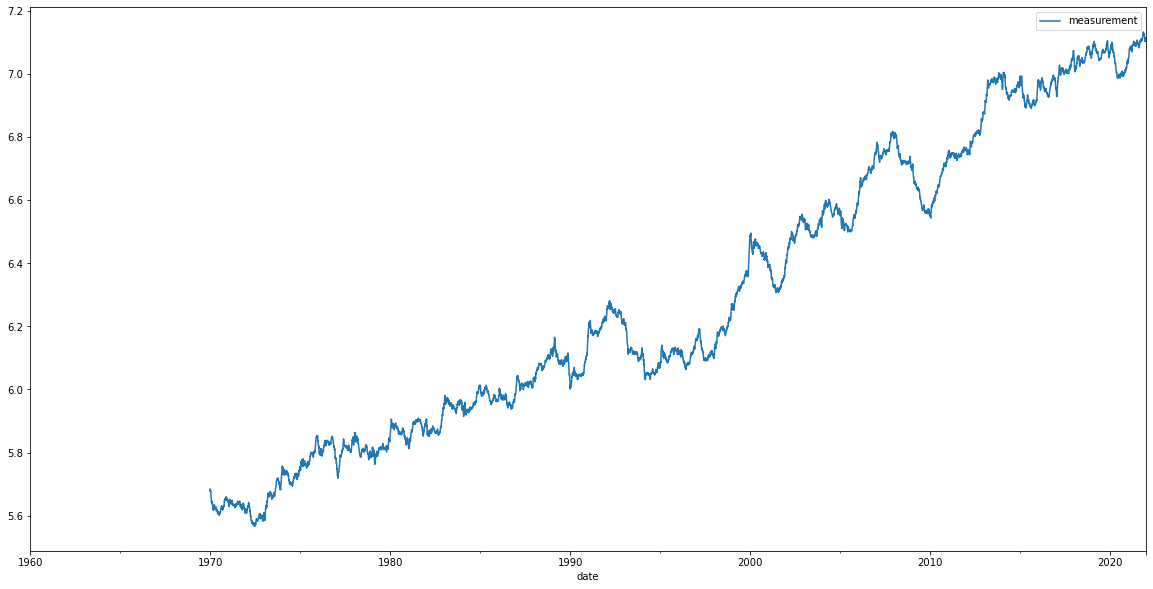

In [4]:
tavg["1960-01-01":].rolling(3650).mean().plot()

measurement
date                   
1951-12-25          NaN
1951-12-26          NaN
1951-12-27          NaN
1951-12-28          NaN
1951-12-29          NaN
1951-12-30          NaN
1951-12-31          NaN
1952-01-01     6.300437
1952-01-02     6.323169
1952-01-03     6.330410
1952-01-04     6.309071
1952-01-05     6.264262

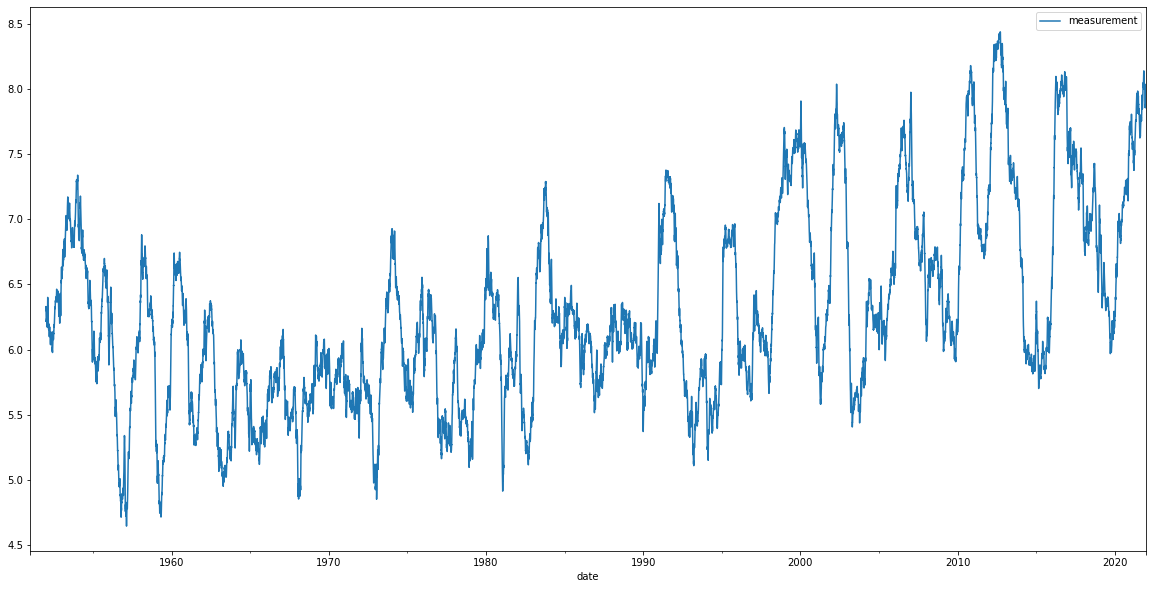

In [5]:
rolling_mean =tavg.rolling(366).mean()
rolling_mean.plot()
rolling_mean.loc["1951-12-25":"1952-01-05"]
# notice exactly one year Nan, our window is backwards looking.

By taking the difference between time t0 and t1 we remove the current level and seasonality from our data to some extent. This allows us to observe the amount of change or volatility in our data from one day to the next.

this is probably useless, but i left it in anyway.
Just because you can plot something doesn't mean it's useful

<AxesSubplot:xlabel='date'>

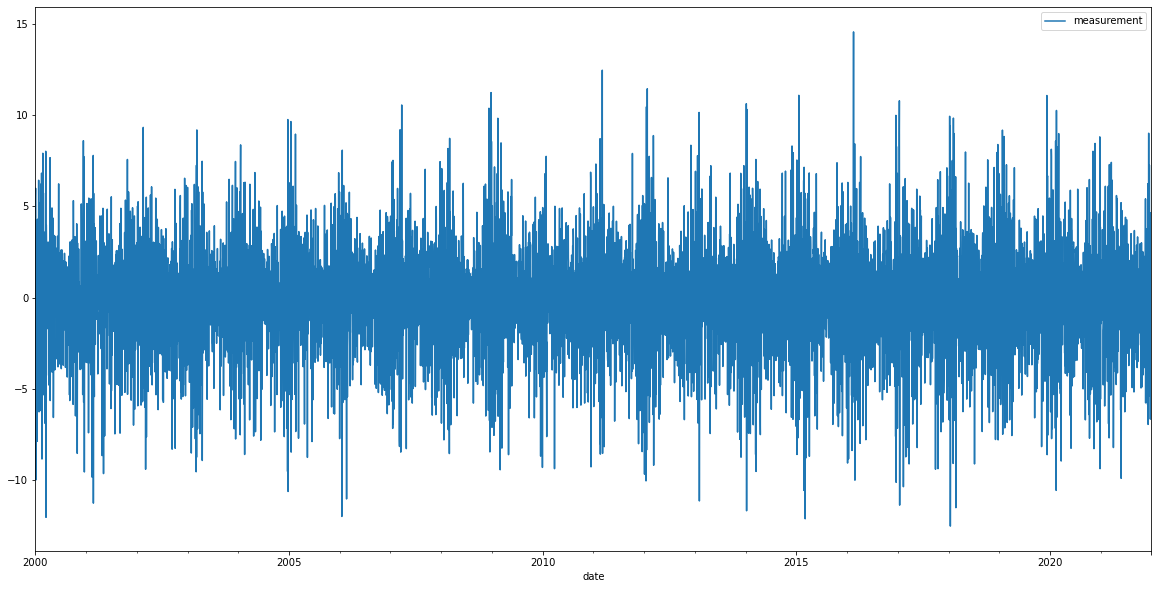

In [6]:
tavg_diff = tavg.diff()
tavg_diff["2000-01-01":].plot()


I can't believe plots are free!

<AxesSubplot:xlabel='date'>

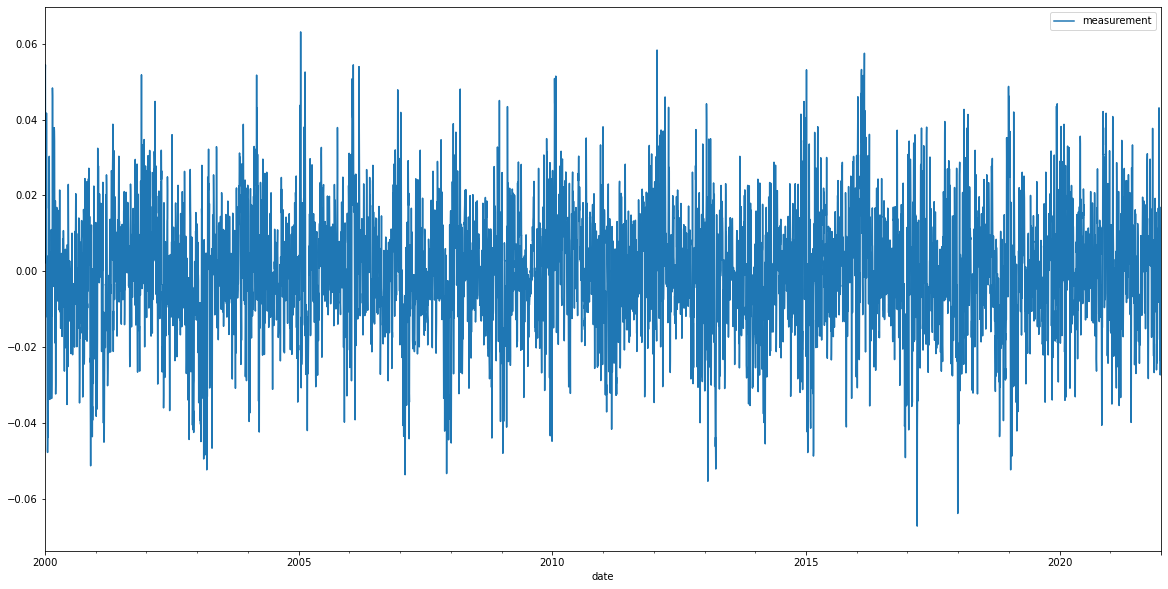

In [7]:
rolling_mean_diff = rolling_mean.diff()
rolling_mean_diff["2000-01-01":].plot()

low p value indicates stationary

again, I'm not sure this is actually useful

In [8]:
dftest = adfuller(rolling_mean_diff.dropna(), autolag = 'AIC')
p_value = dftest[1]

print("p value:",p_value, "statistic",dftest[0]) 

p value: 0.0 statistic -43.498981966900836


I probably would have expected the values to be normally distributed, interesting to see the 2 peaks.

I guess this shows the seasons are somewhat binary, with a relatively small amount of autumn and spring?

<AxesSubplot:ylabel='Density'>

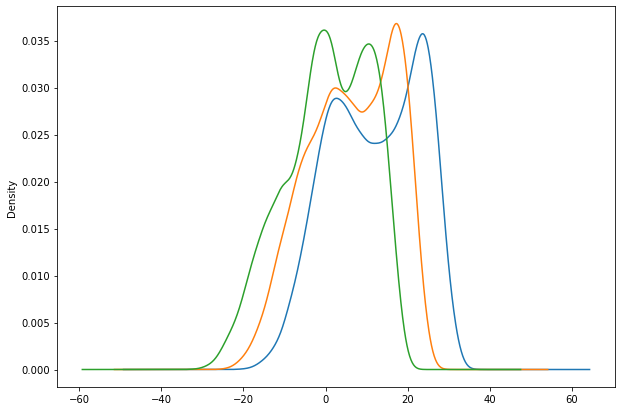

In [9]:
tmax["measurement"].plot(kind="kde", figsize=(10,7))
tavg["measurement"].plot(kind="kde")
tmin["measurement"].plot(kind="kde")

Lets plot the distribution of the mean annual min, max and avg


<AxesSubplot:ylabel='Density'>

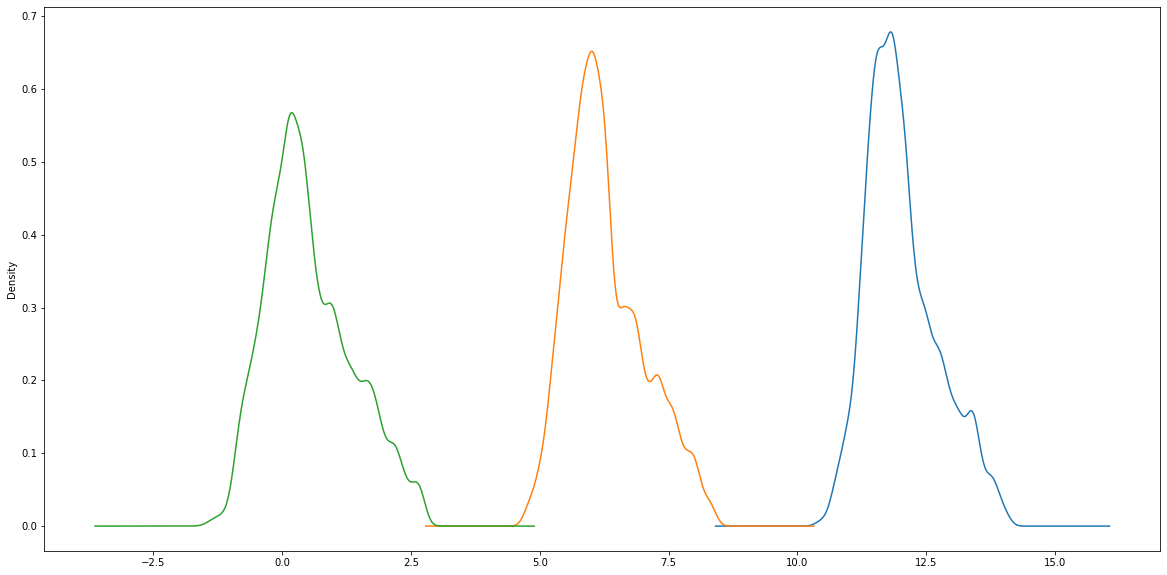

In [10]:
tmax["measurement"].rolling(365).mean().dropna().plot(kind="kde")
tavg["measurement"].rolling(365).mean().dropna().plot(kind="kde")
tmin["measurement"].rolling(365).mean().dropna().plot(kind="kde")

Now lets take a look at precipitation
the rolling annual mean is  1148 and the daily mean is 3.15
The top 75% is only a touch higher at 3.6
This seams to indicate the rainfall is rather steady, with relatively few downpours


In [11]:
rolling_sum = prcp["measurement"].rolling(365).sum().dropna()
display(rolling_sum.mean())
prcp["measurement"].describe()

1148.1556576322891

count    25933.000000
mean         3.148285
std          5.877930
min          0.000000
25%          0.010000
50%          0.540000
75%          3.570000
max         96.240000
Name: measurement, dtype: float64

clearly it tends to rain in small amounts

<AxesSubplot:ylabel='Density'>

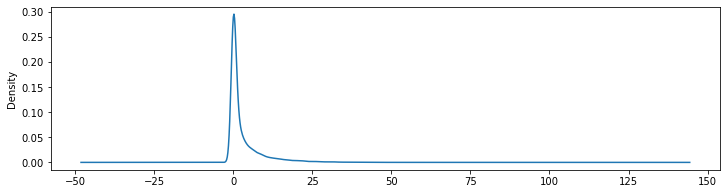

In [12]:
prcp["measurement"].plot(kind="kde", figsize=(12,3))

It looks like the total annual rainfall is normally distributed with a mean of around 1150mm

measurement    1149.922113
dtype: float64

<AxesSubplot:ylabel='Density'>

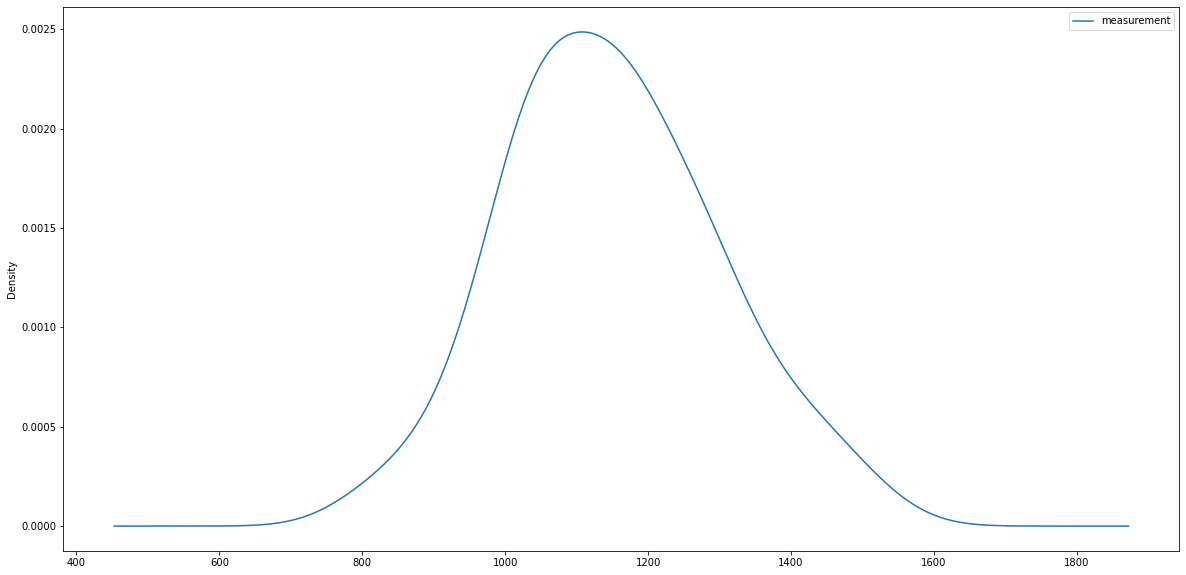

In [13]:
annual_prcp = prcp.groupby(prcp.index.year).sum()
display(annual_prcp.mean())
annual_prcp.plot(kind="kde")

You can edit the start and end dates to get the view you like on the data

In [14]:
start = "2000-01-01"
end = "2006-01-01"

# Variables on y axis
# you can add, edit or remove the rolling mean as required
w = tmax["measurement"].loc[start:end]#.rolling(30).mean().dropna()
y = tavg["measurement"].loc[start:end]#.rolling(30).mean().dropna()
z = tmin["measurement"].loc[start:end]#.rolling(30).mean().dropna()
a = prcp["measurement"].loc[start:end]#.rolling(30).mean().dropna()

# Not sure if volatility is the best word to describe this, we want to see the variance between max and min 
volatility = tmax["measurement"].loc[start:end] - tmin["measurement"].loc[start:end]
volatility = volatility.rolling(90).mean().dropna()


# X axis takes date
x = w.index



volatility

date
2000-03-30    11.498889
2000-03-31    11.480667
2000-04-01    11.465111
2000-04-02    11.487333
2000-04-03    11.474556
                ...    
2005-12-28     9.157000
2005-12-29     9.129111
2005-12-30     9.053667
2005-12-31     9.019222
2006-01-01     8.925000
Name: measurement, Length: 2104, dtype: float64

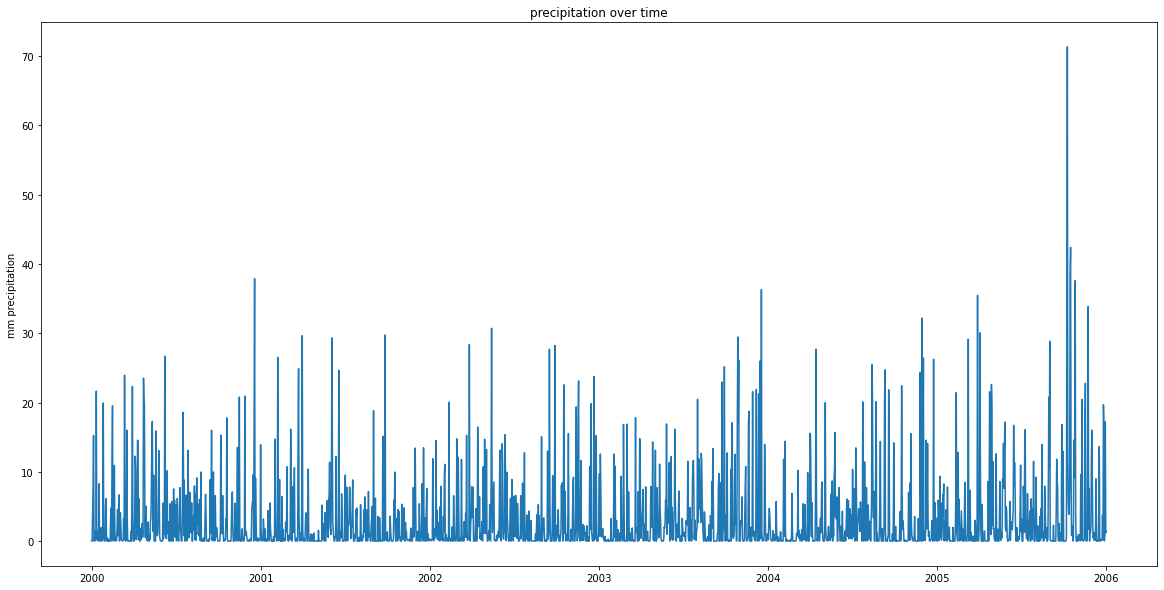

In [15]:
plt.plot(x, a)
plt.ylabel("mm precipitation")
plt.title("precipitation over time")
plt.show()

Text(0.5, 1.0, 'min and max temp over time')

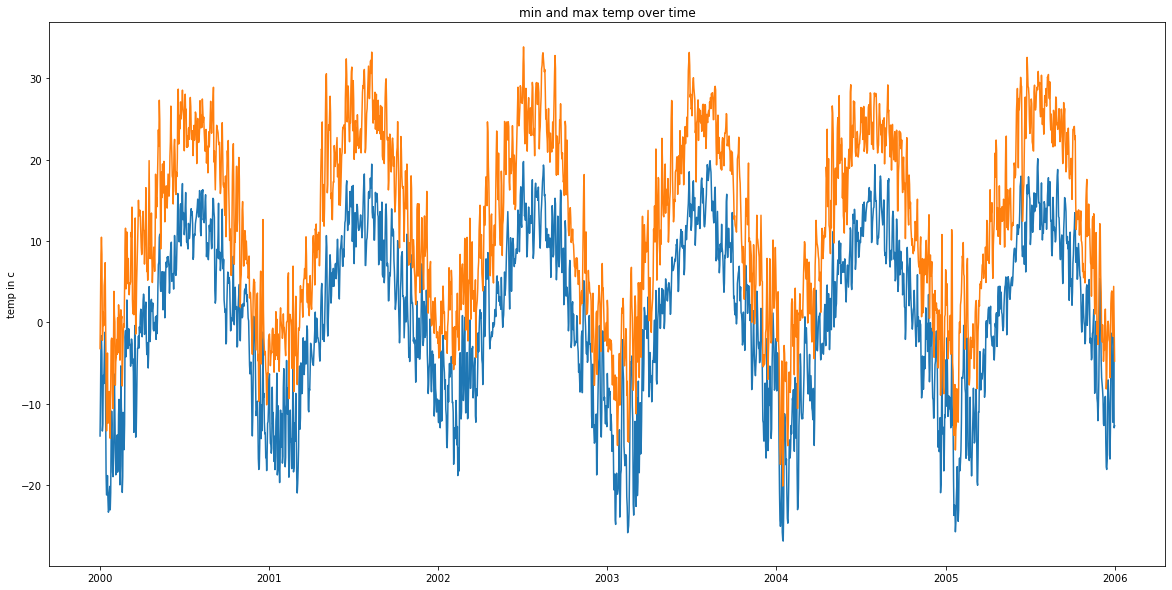

In [16]:
plt.plot(x, z, w)
plt.ylabel("temp in c")
plt.title("min and max temp over time")

In [17]:
volatility = w - y


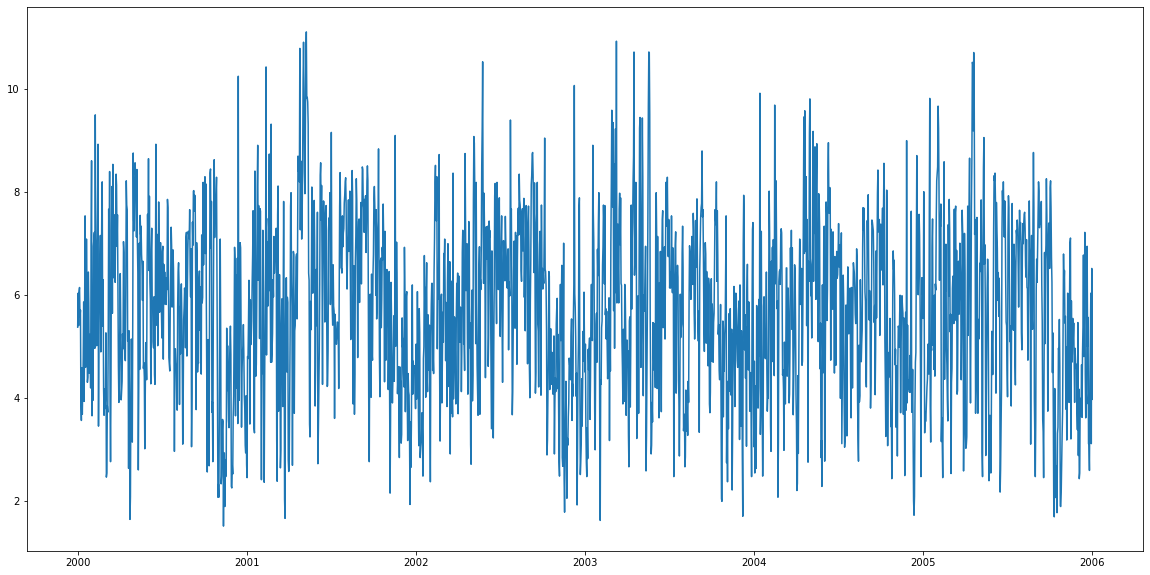

In [18]:
plt.plot(volatility)

In the following code we shift the data set by one day and use todays temperature as our guess for tommorows temperature. This gives us a bench mark for our machine learning models to beat.


the mae is mean absolute error, the mean absolute difference between the prediction and the actual temp
The mean absolute error is only 2.3 for tavg, thus guessing the temp a day in advance based on todays temp is actually a pretty good starting point

In [19]:
shifted = tavg.shift(1).fillna(0)

mae(tavg, shifted)

2.290050900397177

We now do a lag plot to view the correlation between the temperature on one day vs one day ahead.
Clearly the correlation is very high
if you increase the lag it gets lower, but for tavg it stays strong for a very long time.


TIP: try setting a lag of 182, what do you notice?

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

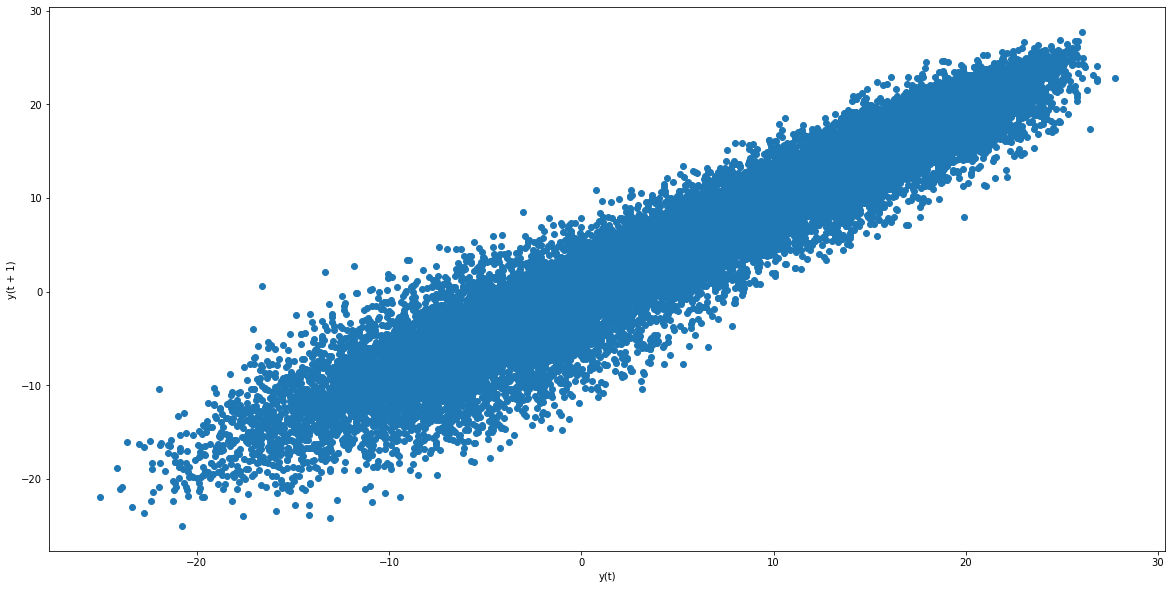

In [20]:
plt.rcParams["figure.figsize"] = (20,10)
pd.plotting.lag_plot(tavg, lag=(1))

Lets create a correlation matrix to view the correlations between the tavg on a given day and a lag of 1, 7, 30, 182 0r 365 days

<AxesSubplot:>

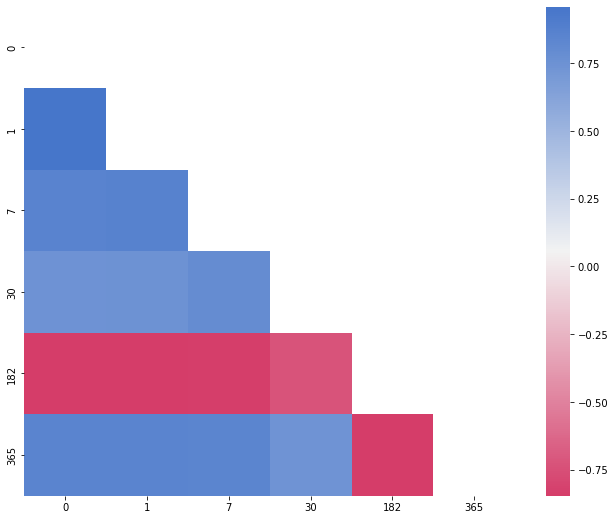

In [23]:
series = tavg

labels = [0,1,7,30,182,365]
correlation = pd.concat([series, series.shift(1), series.shift(7),series.shift(30),series.shift(182),series.shift(365)], axis=1)

correlation = correlation.corr(method = 'pearson')

plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(correlation, dtype=bool))
cmap = sns.diverging_palette(0, 255, sep=2, n=512, as_cmap=True)
sns.heatmap(correlation, mask=mask,cmap=cmap, xticklabels=labels, yticklabels=labels)

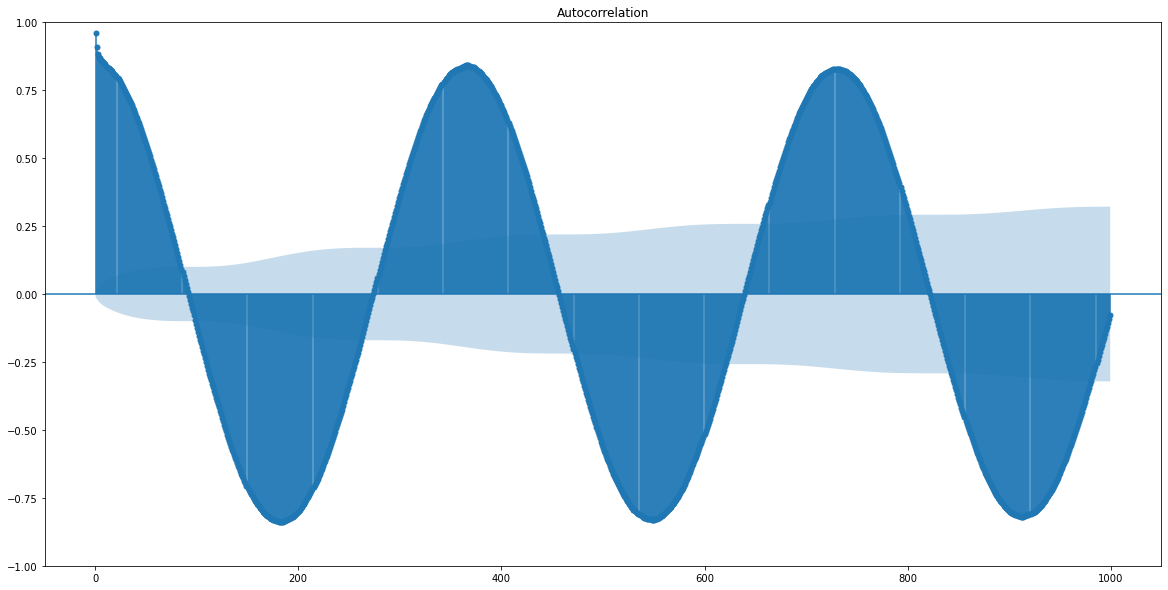

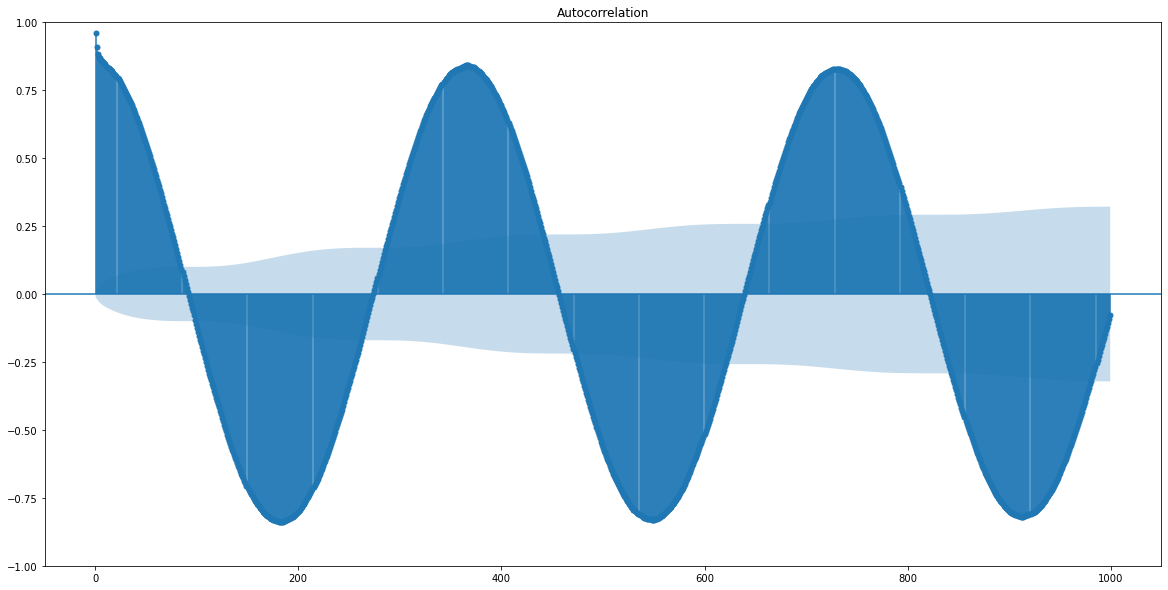

In [26]:
statsmodels.graphics.tsaplots.plot_acf(series, lags=np.arange(1,1000))